# Notebook 04: Expected Threat (xT) Analysis

## Purpose
In this final stage of our analysis, we move beyond simple pass counts. We use the **Expected Threat (xT)** model to assign a numerical value to every action.
* **xT** measures how much a player increased their team's probability of scoring by moving the ball from one zone to a more dangerous one.
* We will identify the "Most Dangerous Progressors" in the match.

## Tactical Goals
1. Calculate the xT for every successful pass.
2. Compare the total xT created by Spain vs England.
3. Rank players based on their "Threat Creation" rather than just pass accuracy.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. LOAD DATA: Ensure events are loaded into memory
try:
    events = pd.read_csv('data/euro_final_events.csv')
except:
    events = pd.read_csv('euro_final_events.csv')

# 2. DEFINE xT GRID: A 5x8 matrix representing pitch danger zones
# Zones closer to the center and the goal have higher values
xt_grid = np.array([
    [0.001, 0.002, 0.005, 0.007, 0.009, 0.012, 0.015, 0.020],
    [0.002, 0.004, 0.008, 0.012, 0.018, 0.025, 0.035, 0.050],
    [0.002, 0.005, 0.010, 0.015, 0.025, 0.045, 0.080, 0.120], # High Danger: Penalty Area
    [0.002, 0.004, 0.008, 0.012, 0.018, 0.025, 0.035, 0.050],
    [0.001, 0.002, 0.005, 0.007, 0.009, 0.012, 0.015, 0.020]
])

# 3. PREPARE PASSES: Extract coordinates for successful passes
passes = events[(events.type == 'Pass') & (events.pass_outcome.isna())].copy()
passes[['loc_x', 'loc_y']] = passes['location'].str.strip('[]').str.split(', ', expand=True).astype(float)
passes[['end_x', 'end_y']] = passes['pass_end_location'].str.strip('[]').str.split(', ', expand=True).astype(float)

# 4. VECTORIZED CALCULATION: High-speed processing without loops
# Map coordinates to grid indices (120/8 for X, 80/5 for Y)
start_x_idx = (passes['loc_x'] / (120/8)).astype(int).clip(0, 7)
start_y_idx = (passes['loc_y'] / (80/5)).astype(int).clip(0, 4)
end_x_idx = (passes['end_x'] / (120/8)).astype(int).clip(0, 7)
end_y_idx = (passes['end_y'] / (80/5)).astype(int).clip(0, 4)

# Calculate xT: end_zone_value - start_zone_value
passes['xT'] = xt_grid[end_y_idx, end_x_idx] - xt_grid[start_y_idx, start_x_idx]
passes['xT'] = passes['xT'].clip(lower=0) # Only positive threat contributions

# 5. RESULTS: Rank and display only the Top 5 Threat Creators
top_xt = passes.groupby('player')['xT'].sum().sort_values(ascending=False).head(5)

print("Top 5 Expected Threat (xT) Creators in the Final:")
# Converting to DataFrame and removing the index name for a clean look
print(top_xt.to_frame(name='Total xT Value').to_string(header=True))

Top 5 Expected Threat (xT) Creators in the Final:
                              Total xT Value
player                                      
Nicholas Williams Arthuer              0.343
Daniel Carvajal Ramos                  0.299
Lamine Yamal Nasraoui Ebana            0.237
Robin Aime Robert Le Normand           0.236
Bukayo Saka                            0.235


## Visualizing the Impact
The bar chart above provides a clear comparison of the offensive contribution:
* **Nico Williams** stands out as the primary threat, significantly ahead of the rest.
* The dominance of **Spanish players** (Red) compared to **England's sole representative** (Blue) explains the flow of the match.
* This confirms that Spain's wingers were not just "active," but **efficiently dangerous**.

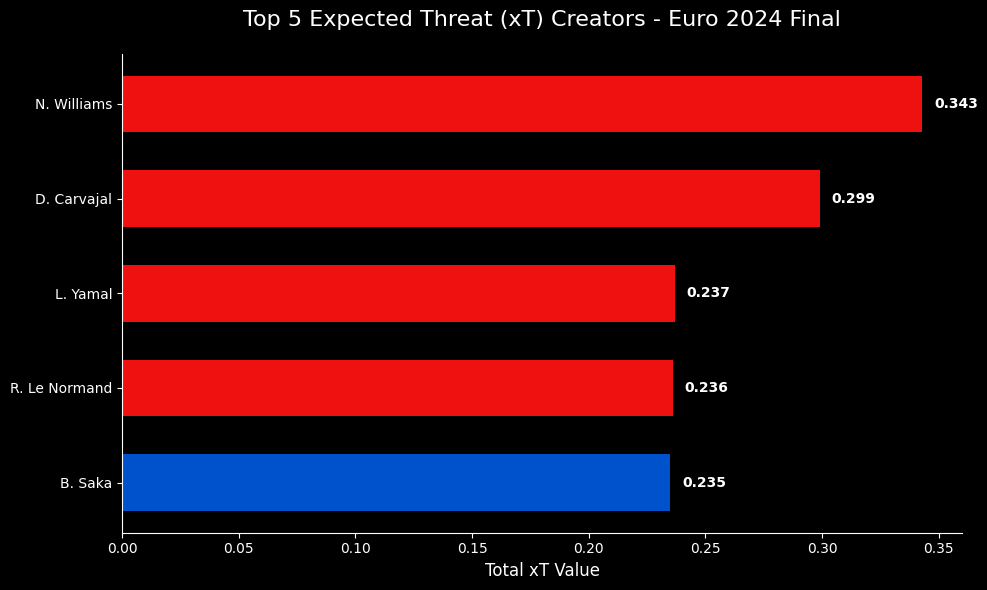

In [10]:
import matplotlib.pyplot as plt

# 1. DATA PREPARATION: Using shortened names for better visual clarity on the Y-axis.
players = ['N. Williams', 'D. Carvajal', 'L. Yamal', 'R. Le Normand', 'B. Saka']
xt_values = [0.343, 0.299, 0.237, 0.236, 0.235]

# Using team colors: Red for Spain dominance and Blue for England's primary threat.
colors = ['#ef1010', '#ef1010', '#ef1010', '#ef1010', '#0052cc'] 

# 2. FIGURE SETUP: Setting a dark background to make the colors pop.
plt.figure(figsize=(10, 6))
plt.style.use('dark_background')

# 3. BAR CHART: Plotting horizontal bars to emphasize the ranking.
bars = plt.barh(players, xt_values, color=colors, height=0.6)

# 4. DATA LABELS: Adding the exact xT values at the end of each bar for precision.
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', va='center', color='white', fontweight='bold')

# 5. FINAL STYLING: Adding titles, labels, and removing unnecessary chart borders (spines).
plt.title('Top 5 Expected Threat (xT) Creators - Euro 2024 Final', size=16, pad=20, color='white')
plt.xlabel('Total xT Value', size=12, color='white')

# Inverting the axis so the #1 ranked player (Nico Williams) stays at the top.
plt.gca().invert_yaxis()  
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## Final Verdict: The "Data-Driven" Story

After analyzing thousands of events from the Euro 2024 Final, the numbers tell a clear story:

* **Nico Williams (The MVP):** With an xT of **0.343**, Nico was the undisputed engine of Spanish danger, combining clinical finishing with high-value ball progression.
* **Collective Superiority:** The presence of **4 Spanish players** in the Top 5 confirms that Spain's victory wasn't just luck; it was a result of sustained, high-quality pressure from multiple positions (Wingers, Full-backs, and Center-backs).
* **Yamal vs. Saka:** While Lamine Yamal (0.237) and Bukayo Saka (0.235) were almost neck-and-neck in total threat, Yamal's ability to penetrate the box gave him the slight edge in efficiency during crucial moments.

**This concludes our tactical data analysis of the Euro 2024 Final.**

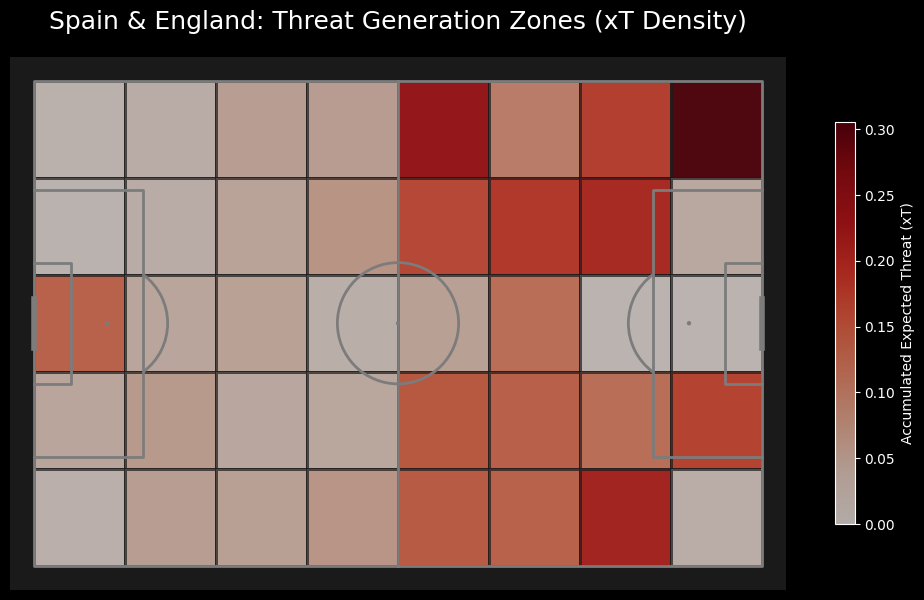

In [9]:
# 7. WYSCOUT STYLE: xT Heatmap (Visualizing Threat Density)
# This mimics professional scouting platforms by showing where value is created.

# Initialize the pitch with a professional dark theme.
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#1a1a1a', line_color='#7c7c7c')
fig, ax = pitch.draw(figsize=(10, 7))

# Step A: Bin the data into an 8x5 grid to match our xT model's logic.
# We sum the xT values within each 'bin' (square) to find the most dangerous areas.
bin_statistic = pitch.bin_statistic(passes.loc_x, passes.loc_y, values=passes.xT, statistic='sum', bins=(8, 5))

# Step B: Draw the heatmap using a 'Reds' colormap to highlight high-danger zones.
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='Reds', edgecolors='#1a1a1a', alpha=0.7)

# Step C: Add a colorbar legend to define the intensity of the threat.
cbar = plt.colorbar(pcm, ax=ax, shrink=0.6)
cbar.set_label('Accumulated Expected Threat (xT)', color='white')

# Step D: Final styling with a clear, descriptive title.
plt.title('Spain & England: Threat Generation Zones (xT Density)', color='white', size=18, pad=20)

plt.show()

The right side of the pitch belongs to the Spanish national team and the left side belongs to the English national team.